In [1]:
import numpy as np
import sys
import gsw
import datetime as dt
from datetime import datetime 
import xarray as xr
import scipy.stats as stats
from scipy.optimize import curve_fit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from xgcm import Grid 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [2]:
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

In [3]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [4]:
da_dep = xr.DataArray(data=dep, dims=["lon","lat"],
    coords=dict(lat=(["lat"], np.nanmean(lats,axis=0)),lon=(["lon"], np.nanmean(lons,axis=1))),
)

In [6]:
# da_dep.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/tile10_depth_est.nc')

In [5]:
# -- mask at the surface and total ocean area -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_grid.rA*ocean_mask)
# -- Gulf of Mexico Mask -- 
ocean_mask = np.ceil(ecco_grid.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
gulf_mask = xr.DataArray(
    data=ocean_mask.isel(tile=tile_num),
    dims=["j", "i"],
    coords=dict(
        i=(["i"], ecco_grid.XC.i.data), j=(["j"], ecco_grid.XC.j.data),
        XC=(["j","i"], ecco_grid.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_grid.YC.isel(tile=tile_num).data), 
    ),
)
lon_w = -98; lon_e = -80; 
lat_s = 17; lat_n = 31; 
gulf_mask = gulf_mask.where(lons > lon_w, np.nan)
gulf_mask = gulf_mask.where(lons < lon_e, np.nan)
gulf_mask = gulf_mask.where(lats > lat_s, np.nan)
gulf_mask = gulf_mask.where(lats < lat_n, np.nan)
# -- subdivisions -- 
sub1 = np.where((lons > -81.75) & (lats > 25))
gulf_mask[np.arange(sub1[0][0],sub1[0][-1]), np.arange(sub1[1][0],sub1[1][-1])] = np.nan
gulf_mask = gulf_mask.where(lons < -81, np.nan)
sub2 = np.where((lons > -88) & (lats < 21.85))
gulf_mask[np.arange(sub2[0][0],sub2[0][-1]), np.arange(sub2[1][0],sub2[1][-1])] = np.nan
sub3 = np.where((lons > -84) & (lats < 23))
gulf_mask[np.arange(sub3[0][0],sub3[0][-1]), np.arange(sub3[1][0],sub3[1][-1])] = np.nan
gulf_area = np.nansum(gulf_mask*ecco_grid.rA.isel(tile=tile_num))
# -- surface and layer areas -- 
h = dep                                               # depth 
A = ecco_grid.rA.isel(tile=tile_num)*gulf_mask        # cell area 
As = gulf_area 
# take layers as cell thicknesses 
imast = ecco_grid.drF.data.cumsum()[0:45]
# loop over each layer and compute area 
AA = []
for i in range(len(imast)):
    AA.append(np.nansum(A.where(h <= imast[i], np.nan)))    # area where depth less than or equal to current depth 
# turn into array 
AAi = np.array([AA.copy()])
AAi[0,0] = As                                               # first value is surface area 
AAi[0,1:] = As - np.array([AA[0:-1]])                       # area in layer i is total area minus area of depths shallower than i 
ii = imast
pbdeps = imast                                              # depths at bottom of each cell 

AAi = xr.DataArray(data=AAi[0,:], dims=["layer"],
    coords=dict(layer=(["layer"], np.arange(0,len(pbdeps))),),
)
print('percent of total area for each layer ' + str(np.round(100*(AAi.data/gulf_area),1)))

percent of total area for each layer [100.   96.4  91.3  86.6  82.5  78.7  75.7  74.2  72.9  72.   71.4  70.4
  69.5  69.   68.3  68.3  67.   66.4  65.2  64.4  63.6  62.7  61.8  61.2
  60.3  59.3  58.   56.6  55.5  53.9  52.2  50.5  49.1  47.9  46.4  44.3
  42.4  40.6  37.2  34.8  32.2  28.3  23.8  12.7   0.1]


In [6]:
# -- load profiles -- 
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/argo_2010_2021_rho.nc')
argo_rho = xr.open_dataset(filename)
a_rho = argo_rho.rho
a_press = argo_rho.pressure
a_z = gsw.z_from_p(a_press,25)
a_lon = argo_rho.lon
a_lat = argo_rho.lat
a_time = argo_rho.time

In [7]:
argo_rho

<xarray.Dataset>
Dimensions:   (pressure: 50, time: 13145)
Coordinates:
  * pressure  (pressure) int64 5 25 45 65 85 105 125 ... 885 905 925 945 965 985
  * time      (time) datetime64[ns] 2010-05-24T07:34:56 ... 2021-12-30T12:34:13
    lon       (time) float64 ...
    lat       (time) float64 ...
Data variables:
    rho       (pressure, time) float64 ...

Text(0.5, 1.0, '505')

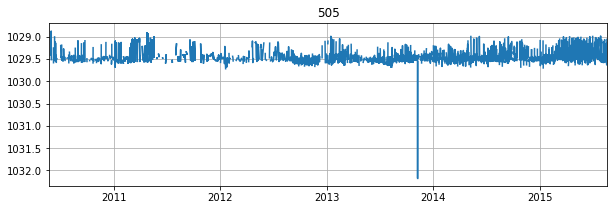

In [8]:
t_dep = 25
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(a_time,a_rho[t_dep,:])
ax.invert_yaxis()
ax.grid()
ax.set_xlim([a_time[0], a_time[4000]])
ax.set_title(str(a_press[t_dep].data))

In [9]:
# convert to ordinal time
a_time_ord = np.nan*np.ones(len(a_time))
for i in range(len(a_time)):
    ts = (np.datetime64(str(a_time[i].data)[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    a_time_ord[i] = ts/(60*60*24)

In [10]:
# -- contruct monthly time record 
mo_rec = np.arange(5.5,12*12,1) # __ year monthly time series (12*#months)
t_rec = []; # t_start = np.datetime64('2010-05-15')
for i in range(len(mo_rec)):
    t_year = np.floor(mo_rec[i]/12) + 2010
    t_month = np.floor(np.mod(mo_rec[i],12)) + 1
    if t_month < 10:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-0' + str(np.int(t_month)) + '-15'))
    else:
        t_rec.append(np.datetime64(str(np.int(t_year)) + '-' + str(np.int(t_month)) + '-15'))

In [11]:
# check conversion 
print(t_rec[-1])
ts = (t_rec[-1] - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
tday = ts/(60*60*24)
print(tday)
datetime.fromordinal(int(tday)) + dt.timedelta(days=tday%1) - dt.timedelta(days=365)

2021-12-15
738504.0


datetime.datetime(2021, 12, 15, 0, 0)

In [12]:
# convert monthly time record to ordinal time
time_ord = np.nan*np.ones(len(t_rec))
for i in range(len(t_rec)):
    ts = (np.datetime64(str(t_rec[i])[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)

In [13]:
# for each month obtain mean density profile 
v_cell_t = ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF            # actual layer thicknesses 
v_cell_t_argo = xr.DataArray(v_cell_t[0:30][:,105,230])
v_cell_z = ecco_grid.Z[0:29]                                            # depth of vertical cell center 

rho_argo = np.nan*np.ones((len(v_cell_z),len(t_rec)))
for i in range(len(t_rec)):
    ts = (t_rec[i] - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    this_time = ts/(60*60*24)
    t_in = np.where((a_time_ord > (this_time - 25)) & (a_time_ord < (this_time + 25)))[0]
    # -- average over longer times to see time scale of pattern) 
    if len(t_in) > 2:
        mean_rho = np.nanmean(a_rho[:,t_in],axis=1)
        good = np.where(~np.isnan(mean_rho))[0]
        # interpolate in the vertical to ECCO grid (for areas)
        rho_argo[:,i] = np.interp(-1*v_cell_z.data,\
                                  -1*a_z[good],mean_rho[good]) 
        

Text(0.5, 1.0, '-55.0')

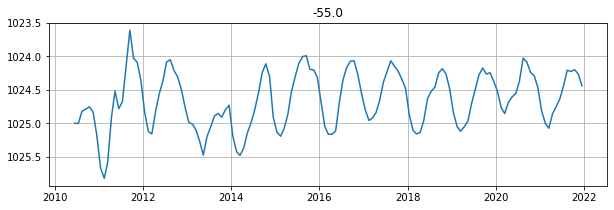

In [14]:
t_dep = 5
f, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(t_rec,rho_argo[t_dep,:])
ax.invert_yaxis()
ax.grid()
# ax.set_xlim([t_rec[0], t_rec[20]])
ax.set_title(str(v_cell_z[t_dep].data))

In [15]:
z_i = np.arange(0,29)
t_i = np.arange(0,len(t_rec))
rho_argo_s = rho_argo[z_i,:][:,t_i] 
den_eg_da = xr.Dataset(
    data_vars=dict(
        rho=(['month','layer'], np.transpose(rho_argo_s)),
        v_cell_thick=(['layer'], v_cell_t_argo[z_i].data),
        AAi_Argo=(['layer'], AAi[z_i].data),
        time=(['month'], t_rec[t_i[0]:])
    ),
    coords=dict(
        month=(["month"], t_i),
        layer=(["layer"], z_i)
    ),
)

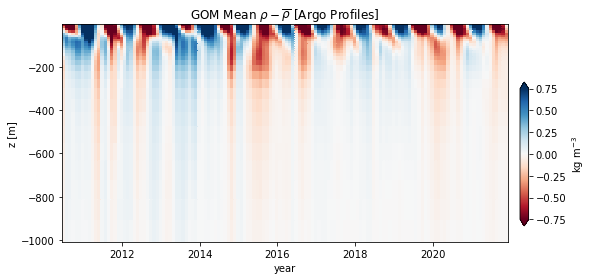

In [16]:
rhobar = np.nanmean(rho_argo[0:29,:],axis=1)
f, ax = plt.subplots(1,1,figsize=(8,4))
# pp = ax.pcolor(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))), cmap='RdBu', vmin=-0.75, vmax=0.75)
# ax.contour(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))), level=[0], linewidths=0.5, colors='k')
cc = ax.pcolor(t_rec, v_cell_z[0:29], \
          np.transpose(den_eg_da.rho.data - np.transpose(np.tile(rhobar[:,None],(1,len(t_rec))))), \
          cmap='RdBu', vmin=-0.75, vmax=0.75)
ax.set_title(r'GOM Mean $\rho - \overline{\rho}$ [Argo Profiles]')
ax.set_ylabel('z [m]'); 
ax.set_xlabel('year'); 
ax.set_xlim([t_rec[0], t_rec[-1]])
cbpos = [0.92, 0.18, 0.015, 0.5]; 
cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label=r'kg m$^{-3}$')

In [17]:
# -- Run Landerer Model -- 
# constants 
g = 9.81 
rho0 = 1029
delta_pb_total = np.nan*np.ones((np.shape(den_eg_da.rho)[0],np.shape(den_eg_da.rho)[1]))
lay1 = np.nan*np.ones((np.shape(den_eg_da.rho)[0]))
layb = np.nan*np.ones((np.shape(den_eg_da.rho)[0],len(v_cell_z)-1))
for tt in range(np.shape(den_eg_da.rho)[0]):                            # loop over all times 
    for m in range(0,29):                                               # loop over all layers 
        this_i = np.where(-1*v_cell_z <= -1*v_cell_z[m])[0]             # all depths shallower than depth i 
        this_i = this_i[-1]                                             # deepest index (the layer we care about in this loop)
    
        below_i = np.arange(this_i+1,len(v_cell_z))
        above_i = np.arange(0,this_i+1)
    
        # -- for each layer, multiply rho_prime by layer thickness, then average across basin 
        below = (1/rho0)*( (den_eg_da.AAi_Argo.isel(layer=below_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=below_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=below_i))).sum(dim='layer')
        above = (1/rho0)*((As/den_eg_da.AAi_Argo.isel(layer=above_i) - 1)*(den_eg_da.AAi_Argo.isel(layer=above_i)/As)*\
                           (den_eg_da.v_cell_thick.isel(layer=above_i)*\
                           -1*den_eg_da.rho.isel(month=tt,layer=above_i))).sum(dim='layer')
        delta_pb_total[tt,m] = below.data - above.data

# output as data array 
deltapbz_total = xr.DataArray(data=np.transpose(delta_pb_total), dims=["zi","time"],
                        coords=dict(
                            zi=(["zi"], v_cell_z.data),
                            time=(["time"], den_eg_da.time.data),
                        ),
                       )

In [18]:
den_eg_da.time[-25].data

array('2019-12-15T00:00:00.000000000', dtype='datetime64[ns]')

In [16]:
# -- time period to fit over -- 
# t_s = str(den_eg_da.time[0].data) # START = 2010-06-01 
# t_e = '2019-12-15'
# test = (deltapbz_total.sel(time=slice(t_s, t_e)) - deltapbz_total.sel(time=slice(t_s, t_e)).mean(dim=['time']))
# p_test = test.polyfit(dim='time', deg=1)
# p_test = (p_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

t_l_s = str(den_eg_da.time[0].data) 
t_l_e = str(den_eg_da.time[-19].data)
print(t_l_s)
print(t_l_e)
test = (deltapbz_total.sel(time=slice(t_l_s, t_l_e)) - deltapbz_total.sel(time=slice(t_l_s, t_l_e)).mean(dim=['time']))
p_l_test = test.polyfit(dim='time', deg=1)
p_l_test = (p_l_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365

2010-06-15T00:00:00.000000000
2020-06-15T00:00:00.000000000


In [19]:
t_l_s = str(den_eg_da.time[0].data) 
t_l_e = str(den_eg_da.time[-19].data)
print(t_l_s)
print(t_l_e)
test = (deltapbz_total.sel(time=slice(t_l_s, t_l_e)) - deltapbz_total.sel(time=slice(t_l_s, t_l_e)).mean(dim=['time']))
p_l_test = np.nan*test[:,0].copy()
for i in range(np.shape(test)[0]):
    redis_fit = curve_fit(seasonal_plus_trend, time_ord[0:-18] - time_ord[0:-18][0], test[i,:])
    p_l_test[i] = redis_fit[0][4]*365

2010-06-15T00:00:00.000000000
2020-06-15T00:00:00.000000000


(14775.0, 18245.0)

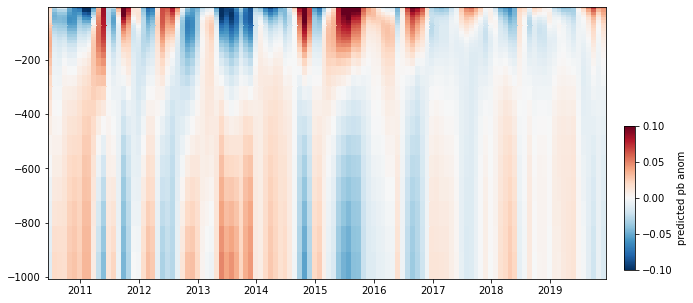

In [20]:
# argo_predicted_pb_prime = deltapbz_total - deltapbz_total.mean(dim=['time'])
f, ax = plt.subplots(1,1,figsize=(10,5))
cc = ax.pcolor(deltapbz_total.sel(time=slice(t_l_s, t_l_e)).time, v_cell_z, test, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
# ax.contour(t_rec,v_cell_z[0:29],rho_argo[0:29,:] - np.tile(rhobar[:,None],(1,len(t_rec))),level=[0],linewidths=0.75,colors='k')
cbpos = [0.925, 0.15, 0.015, 0.4]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', label='predicted pb anom')
ax.set_xlim([den_eg_da.time[0].data,den_eg_da.time[-25].data])

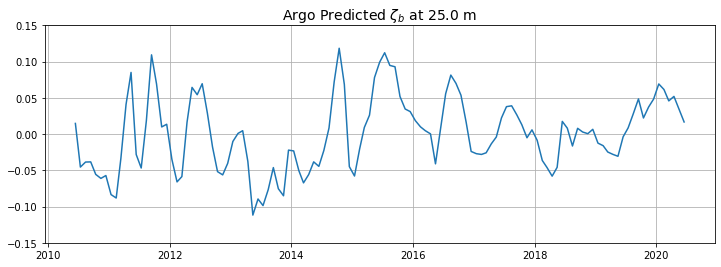

In [36]:
d_i = 2
f, ax = plt.subplots(1,1,figsize=(12,4))
# ax.plot(deltapbz_total.time.sel(time=slice(t_s, t_e)).data,test[1,:])
ax.plot(deltapbz_total.time.sel(time=slice(t_l_s, t_l_e)).data,test[d_i,:])
ax.set_title(r'Argo Predicted $\zeta_b$ at ' + str(-1*v_cell_z[d_i].data) + ' m', fontsize=14)
ax.set_ylim([-0.15,0.15])
ax.grid()

In [55]:
argo_pred_obp_a = xr.Dataset(
    data_vars=dict(
        argo_obp = (['time'], test[d_i,:].data),
    ),
    coords=dict(
        time=(["time"], deltapbz_total.time.sel(time=slice(t_s, t_e)).data)
    ),
)
argo_pred_obp_a.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/argo_obp_50m_2010_2019.nc')

In [21]:
ds_ecco_landerer = xr.open_dataset('/Users/jakesteinberg/Documents/NASA_OSTST/ecco_landerer_trend_prediction.nc')

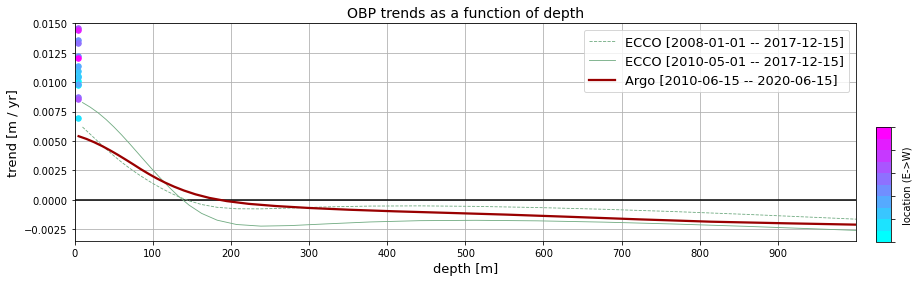

In [22]:
f,ax = plt.subplots(1,1,figsize=(14,4))
ax.plot([0,3000],[0, 0], color='k', linewidth=1.5, linestyle='-')

cmap = mpl.cm.get_cmap('cool',10)
clow = 0; chigh = 1; 
norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)
tg_trends = np.array([0.01010977, 0.00977133, 0.01054144, 0.00695134, 0.01096931, 0.01043873, 0.00982837, 0.01140618, 0.01356605, 0.01220623,
       0.00875021, 0.01335275, 0.01461547, 0.00856436, 0.02142472, 0.02116908, 0.01556622, 0.01439639, 0.01205811])
for i in range(len(tg_trends)):
    ax.scatter(4,tg_trends[i],s=30,color=[cmap((i)/len(tg_trends))],zorder=2)
cbpos = [0.92, 0.12, 0.015, 0.4]; cax = f.add_axes(cbpos); 
fc = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='vertical', label='location (E->W)')   
fc.ax.set_yticklabels([''])

ax.plot(ds_ecco_landerer.depth,ds_ecco_landerer.p_test,label='ECCO [2008-01-01 -- 2017-12-15]', color='#71AB82',linestyle='--', linewidth=0.85)
ax.plot(ds_ecco_landerer.depth,ds_ecco_landerer.p_test8,label='ECCO [2010-05-01 -- 2017-12-15]', color='#71AB82', linewidth=0.85)
# ax.plot(-1*v_cell_z.data, p_test, color='#FF7F50', linewidth=2.5, label='Argo [' + t_s[0:10] + ' -- ' + t_e[0:10] + ']')
# ax.scatter(-1*v_cell_z.data, p_test, color='#FF7F50', s=10)
ax.plot(-1*v_cell_z.data, p_l_test, color='#990000', linewidth=2.25, label='Argo [' + t_l_s[0:10] + ' -- ' + t_l_e[0:10] + ']')
ax.set_xlim([0,1000]); ax.set_xticks(np.arange(0,1000,100)); ax.set_xlabel('depth [m]',fontsize=13)
ax.set_ylabel('trend [m / yr]',fontsize=13); ax.set_ylim([-0.0035, 0.015]);
ax.grid(); ax.set_title('OBP trends as a function of depth',fontsize=14); ax.legend(fontsize=13)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_06_23/argo_landerer_w_tg.jpg', dpi=250)

In [23]:
p_l_test

<xarray.DataArray (zi: 29)>
array([ 0.00539905,  0.00516806,  0.00488514,  0.00456439,  0.00420624,
        0.00382435,  0.00341927,  0.00300311,  0.0025777 ,  0.00217735,
        0.00179914,  0.00144601,  0.00110935,  0.00077992,  0.00045637,
        0.00014832, -0.0001252 , -0.00035617, -0.00054217, -0.00070688,
       -0.0008554 , -0.00099223, -0.00112349, -0.00127213, -0.00146172,
       -0.00167554, -0.00187489, -0.00201054, -0.00213446])
Coordinates:
  * zi       (zi) float32 -5.0 -15.0 -25.0 -35.0 ... -814.5 -909.7 -1.007e+03
    time     datetime64[ns] 2010-06-15

In [24]:
p_l_test.to_netcdf(path='/Users/jakesteinberg/Documents/NASA_OSTST/argo_redist_pred_2010_2020.nc')

In [23]:
np.shape((deltapbz_total.sel(time=slice(t_l_s, t_l_e)) - deltapbz_total.sel(time=slice(t_l_s, t_l_e)).mean(dim=['time'])))

(29, 121)

In [40]:
def pharand(u):
    [n,m] = np.shape(u)
    n2 = np.fix(n/2)
    # if 2*n2 == n:
    #     n2 = np.int(n2)
    if 2*n2 < n:     # if odd 
        n2 = n2 + 1
    n2 = np.int(n2)
    U = np.fft.fft(u,axis=0)
    R=np.abs(U[0:n2,:])
    theta=np.random.rand(n2,m)*2*np.pi
    P=np.exp(1j*theta)
    U1top = R*P
    U2bot=np.conj(np.flipud(U1top))
    if 2*n2 == n:
        ## EVEN 
        # U1 = np.concatenate((U1top, U[n2+1,:][:,None], U2bot[1:n2,:]),axis=0) # if single column
        U1 = np.concatenate((U1top, U[n2,:][None,:], U2bot[0:n2-1,:]),axis=0)
    else:
        # ODD 
        U1 = np.concatenate((U1top, U2bot[0:n2-1,:]),axis=0)    
    U1[0,:] = U[0,:]
    u1 = np.transpose(np.real(np.fft.ifft(U1,axis=0)))
    return u1

In [49]:
np.shape(data_in)

(121, 29)

In [50]:
# PHASE SCRAMBLING
test_a = (deltapbz_total.sel(time=slice(t_l_s, t_l_e)) - deltapbz_total.sel(time=slice(t_l_s, t_l_e)).mean(dim=['time']))
# -- consider input dimension, want [time, station]
# - if more than 1d
data_in = test_a.data.transpose()
# if a single column
# data_in = test_a.data[:,None]
n_s = 1000
scram_trend = np.nan*np.ones((n_s,np.shape(data_in)[1]))
for i in range(0,n_s):
    scram = pharand(data_in)
    u1_da = xr.DataArray(data=scram, dims=["location","time"],
                        coords=dict(
                            location=(["location"], np.arange(0,np.shape(scram)[0])), time=(["time"], test_a.time.data))) # not location, really depth
    
    # slope = u1_da.polyfit(dim='time', deg=1)
    # scram_trend[i,:] = (slope.isel(degree=0).polyfit_coefficients.data)*1e9*60*60*24*365 
    
    for j in range(np.shape(u1_da)[0]):
        redis_fit = curve_fit(seasonal_plus_trend, time_ord[0:-18] - time_ord[0:-18][0], u1_da[j,:].data)
        scram_trend[i,j] = redis_fit[0][4]*365

tg:0.0054, std:0.0034
tg:0.0052, std:0.0032
tg:0.0049, std:0.0031
tg:0.0046, std:0.0031
tg:0.0042, std:0.0029
tg:0.0038, std:0.0027
tg:0.0034, std:0.0025
tg:0.003, std:0.0024
tg:0.0026, std:0.0022
tg:0.0022, std:0.002
tg:0.0018, std:0.0019
tg:0.0014, std:0.0017
tg:0.0011, std:0.0016
tg:0.0008, std:0.0014
tg:0.0005, std:0.0012


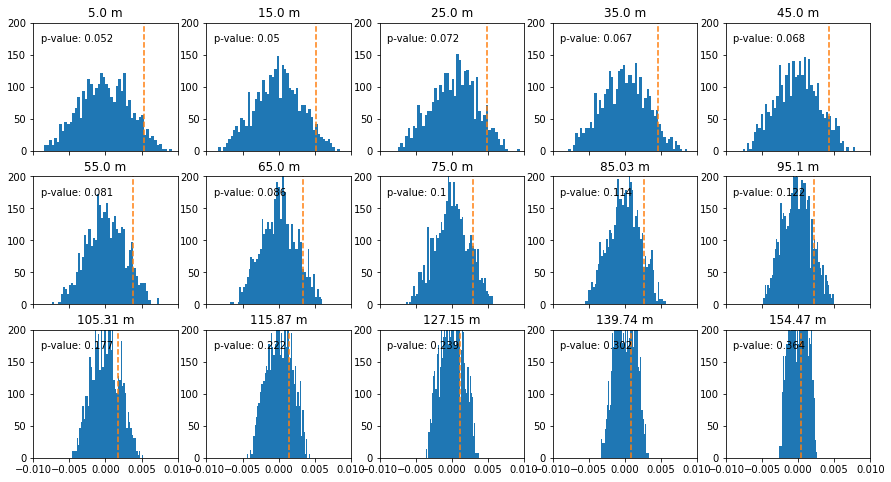

In [51]:
combo_dist = np.concatenate((scram_trend,p_l_test.data[None,:]),axis=0)
zscores = stats.zscore(combo_dist,axis=0)
p_value = stats.norm.sf(abs(zscores[-1,:])) # one-sided vs. two-sided distribution? 

f, ax = plt.subplots(3,5,figsize=(15,8))
gax = ax.flatten()
for ii in range(15):
    ah = gax[ii].hist(scram_trend[:,ii],50,density=True)
    gax[ii].plot([p_l_test[ii],p_l_test[ii]],[0,200],linestyle='--')
    gax[ii].set_title(str(np.round(-1*v_cell_z.data[ii],2)) + ' m')
    gax[ii].set_ylim([0,200])
    gax[ii].set_xlim([-0.01,0.01])
    gax[ii].text(-0.009,170,'p-value: ' + str(np.round(p_value[ii],3)))
    print('tg:' + str(np.round(p_l_test[ii].data,4)) + ', std:' + str(np.round(np.nanstd(scram_trend[:,ii]),4)))
    if ii <= 9:
        gax[ii].set_xticklabels('')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_08_18/argo_trend_dist.jpg', dpi=250)

In [44]:
combo_dist = np.concatenate((scram_trend,p_l_test.data[None,:]),axis=0)
zscores = stats.zscore(combo_dist,axis=0)
p_value = stats.norm.sf(abs(zscores[-1,:])) # one-sided vs. two-sided distribution? 
p_value[0:15]

array([0.1568741 , 0.17174391, 0.15254343, 0.13357123, 0.14860562,
       0.14429323, 0.17247151, 0.19686135, 0.206955  , 0.25080022,
       0.29571932, 0.35807639, 0.44487165, 0.49542684, 0.62412336])

In [3]:
stats.norm.sf?

Signature: stats.norm.sf(x, *args, **kwds)
Docstring:
Survival function (1 - `cdf`) at x of the given RV.

Parameters
----------
x : array_like
    quantiles
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information)
loc : array_like, optional
    location parameter (default=0)
scale : array_like, optional
    scale parameter (default=1)

Returns
-------
sf : array_like
    Survival function evaluated at x
File:      ~/anaconda3/envs/ECCOv4_py/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method
